# Installing and importing the necessary modules


In [5]:
pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [45]:
import psycopg2 as psycop
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
import warnings
warnings.filterwarnings('ignore')

# function to get a connection to DB

In [7]:
def get_db_connection():
    """
    Retrieve connection to the Postgres DB.
    """
    connection = psycop.connect(
        host="host.docker.internal",
        dbname="google_trends",
        port=5432,
        user="postgres",
        password="postgres",
    )
    connection.autocommit = True

    return connection

# API to fetch real time data from postgres

In [12]:
def fetch_real_time_data_from_postgres():
    connection = get_db_connection()
    
    select_query = """
    select distinct * from google_trends_data
    where topic = 'play station' 
    order by 
    google_trends_data.date_stamp 
    desc
    limit 5
    """
    
    df = pd.read_sql_query(select_query, connection)
    
    connection.close()
    
    return df
    

# sample run

In [26]:
print(fetch_real_time_data_from_postgres())

          topic                date_stamp  frequency
0  play station  Apr 15, 2023 at 11:57 PM       22.0
1  play station  Apr 15, 2023 at 11:56 PM       49.0
2  play station  Apr 15, 2023 at 11:55 PM        0.0
3  play station  Apr 15, 2023 at 11:54 PM        0.0
4  play station  Apr 15, 2023 at 11:53 PM       22.0


# looping 3 times with an hour time sleep each time 

In [27]:
import time
for _ in range(3):
    df = fetch_real_time_data_from_postgres()
    print("------------------------------------------------------")
    print(df)
    time.sleep(60 * 60)
    

------------------------------------------------------
          topic                date_stamp  frequency
0  play station  Apr 15, 2023 at 11:57 PM       22.0
1  play station  Apr 15, 2023 at 11:56 PM       49.0
2  play station  Apr 15, 2023 at 11:55 PM        0.0
3  play station  Apr 15, 2023 at 11:54 PM        0.0
4  play station  Apr 15, 2023 at 11:53 PM       22.0
------------------------------------------------------
          topic               date_stamp  frequency
0  play station  Apr 16, 2023 at 1:53 AM       26.0
1  play station  Apr 16, 2023 at 1:52 AM       28.0
2  play station  Apr 16, 2023 at 1:51 AM       61.0
3  play station  Apr 16, 2023 at 1:50 AM       20.0
4  play station  Apr 16, 2023 at 1:49 AM       22.0
------------------------------------------------------
          topic               date_stamp  frequency
0  play station  Apr 16, 2023 at 1:53 AM       26.0
1  play station  Apr 16, 2023 at 1:52 AM       28.0
2  play station  Apr 16, 2023 at 1:51 AM       61

# API to fetch historical data from postgres

In [31]:
def fetch_historical_data_from_postgres():
    connection = get_db_connection()
    
    select_query = """
    select distinct * from google_trends_data
    where topic = 'washing machines' 
    """
    
    df = pd.read_sql_query(select_query, connection)
    
    connection.close()
    
    return df

# fetching historical data from API and storing as a Dataframe

In [35]:
historical_data_df = fetch_historical_data_from_postgres()
print(historical_data_df)

                topic date_stamp  frequency
0    washing machines   Nov 2017       35.0
1    washing machines   Mar 2023       24.0
2    washing machines   Jan 2011       59.0
3    washing machines   Aug 2018       34.0
4    washing machines   Jul 2022       27.0
..                ...        ...        ...
227  washing machines   Apr 2020       30.0
228  washing machines   Oct 2012       36.0
229  washing machines   Feb 2004       95.0
230  washing machines   Mar 2016       32.0
231  washing machines   Sep 2009       72.0

[232 rows x 3 columns]


# looking for anomalies 

In [ ]:
def look_for_anomalies(df):

    status = None
    check = None
    
    if len(df[df["frequency"] < 0]) >= 1:
        status = "FAILED: search frequencies less than 0"
        check = False

    elif len(df[df["frequency"] > 100]) >= 1:
        status = "FAILED: search frequencies greater than 100"
        check = False

    else:
        status = "PASSED: all frequencies, within the acceptable range"
        check = True
    
    return status, check

In [51]:
status, check = look_for_anomalies(historical_data_df)

In [52]:
print("check: ", check)
print(status)

check:  True
PASSED: all frequencies, within the acceptable range


# Adding an anomaly to check if the function works

In [53]:
historical_data_df.loc[0, 'frequency'] = 101

In [56]:
status, check = look_for_anomalies(historical_data_df)

In [57]:
print("check: ", check)
print(status)

check:  False
FAILED: search frequencies greater than 100


In [58]:
historical_data_df.loc[0, 'frequency'] = 35

# Performing exploratory data analysis

In [59]:
historical_data_df.head()

,topic,date_stamp,frequency
0,washing machines,Nov 2017,35.0
1,washing machines,Mar 2023,24.0
2,washing machines,Jan 2011,59.0
3,washing machines,Aug 2018,34.0
4,washing machines,Jul 2022,27.0


In [60]:
historical_data_df.tail()

,topic,date_stamp,frequency
227,washing machines,Apr 2020,30.0
228,washing machines,Oct 2012,36.0
229,washing machines,Feb 2004,95.0
230,washing machines,Mar 2016,32.0
231,washing machines,Sep 2009,72.0


In [62]:
# Find the maximum value of the Frequency column
max_freq = historical_data_df['frequency'].max()
print('Maximum Frequency:', max_freq)

# Find the minimum value of the Frequency column
min_freq = historical_data_df['frequency'].min()
print('Minimum Frequency:', min_freq)

Maximum Frequency: 100.0
Minimum Frequency: 24.0


In [63]:
historical_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   topic       232 non-null    object 
 1   date_stamp  232 non-null    object 
 2   frequency   232 non-null    float64
dtypes: float64(1), object(2)
memory usage: 5.6+ KB


In [64]:
historical_data_df.nunique()

topic           1
date_stamp    232
frequency      62
dtype: int64

In [68]:
historical_data_df.isnull().sum()

topic         0
date_stamp    0
frequency     0
dtype: int64

In [69]:
# Descriptive statics 
historical_data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
frequency,232.0,48.586207,18.698366,24.0,34.0,40.0,65.0,100.0


In [74]:
historical_data_df['date_stamp']= pd.to_datetime(historical_data_df['date_stamp'])

In [76]:
historical_data_df = historical_data_df.sort_values(by='date_stamp')

In [77]:
historical_data_df

,topic,date_stamp,frequency
15,washing machines,2004-01-01,100.0
229,washing machines,2004-02-01,95.0
210,washing machines,2004-03-01,86.0
59,washing machines,2004-04-01,82.0
70,washing machines,2004-05-01,87.0
...,...,...,...
74,washing machines,2022-12-01,25.0
125,washing machines,2023-01-01,26.0
120,washing machines,2023-02-01,25.0
1,washing machines,2023-03-01,24.0


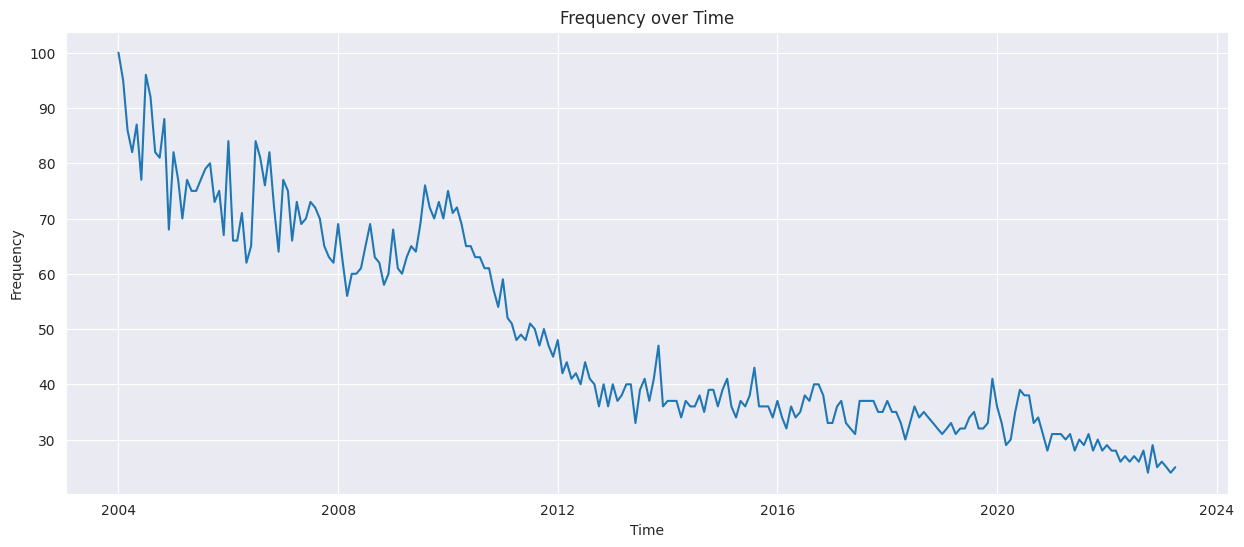

In [78]:
# Set the plot style to "darkgrid"
sns.set_style("darkgrid")

# Set the plot size to 10 inches wide by 6 inches tall
plt.figure(figsize=(15, 6))

# Create the plot using the lineplot() function
sns.lineplot(data=historical_data_df, x='date_stamp', y='frequency')

# Set the plot title and axis labels
plt.title('Frequency over Time')
plt.xlabel('Time')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [79]:
def fetch_real_time_data_to_plot():
    connection = get_db_connection()
    
    select_query = """
    select distinct * from google_trends_data
    where topic = 'play station' 
    order by 
    google_trends_data.date_stamp 
    """
    
    df = pd.read_sql_query(select_query, connection)
    
    connection.close()
    
    return df

In [83]:
real_time_data_for_plotting_df = fetch_real_time_data_to_plot()

In [84]:
real_time_data_for_plotting_df['date_stamp']= pd.to_datetime(real_time_data_for_plotting_df['date_stamp'])
real_time_data_for_plotting_df = real_time_data_for_plotting_df.sort_values(by='date_stamp')


In [85]:
real_time_data_for_plotting_df

,topic,date_stamp,frequency
0,play station,2023-04-15 23:01:00,39.0
1,play station,2023-04-15 23:02:00,0.0
2,play station,2023-04-15 23:03:00,27.0
3,play station,2023-04-15 23:04:00,24.0
4,play station,2023-04-15 23:05:00,100.0
...,...,...,...
109,play station,2023-04-16 01:49:00,22.0
110,play station,2023-04-16 01:50:00,20.0
111,play station,2023-04-16 01:51:00,61.0
112,play station,2023-04-16 01:52:00,28.0


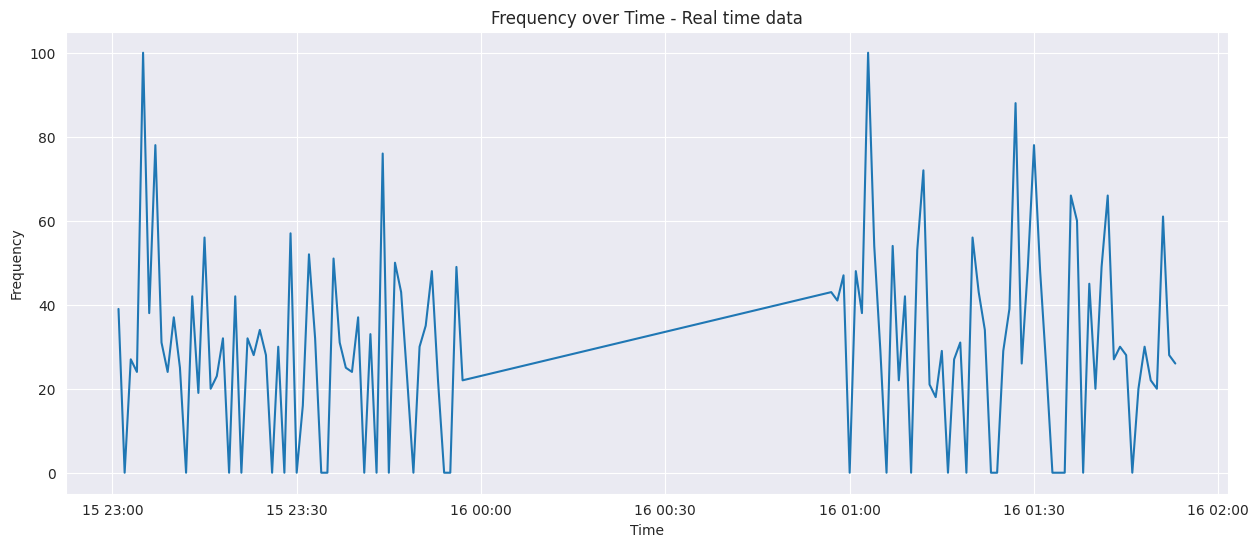

In [86]:
# Set the plot style to "darkgrid"
sns.set_style("darkgrid")

# Set the plot size to 10 inches wide by 6 inches tall
plt.figure(figsize=(15, 6))

# Create the plot using the lineplot() function
sns.lineplot(data=real_time_data_for_plotting_df, x='date_stamp', y='frequency')

# Set the plot title and axis labels
plt.title('Frequency over Time - Real time data')
plt.xlabel('Time')
plt.ylabel('Frequency')

# Show the plot
plt.show()